### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um im√≥vel de qualquer tipo (apartamento, casa, chal√©, pousada, etc.) pode ofertar o seu im√≥vel para ser alugado por di√°ria.

Voc√™ cria o seu perfil de host (pessoa que disponibiliza um im√≥vel para aluguel por di√°ria) e cria o an√∫ncio do seu im√≥vel.

Nesse an√∫ncio, o host deve descrever as caracter√≠sticas do im√≥vel da forma mais completa poss√≠vel, de forma a ajudar os locadores/viajantes a escolherem o melhor im√≥vel para eles (e de forma a tornar o seu an√∫ncio mais atrativo)

Existem dezenas de personaliza√ß√µes poss√≠veis no seu an√∫ncio, desde quantidade m√≠nima de di√°ria, pre√ßo, quantidade de quartos, at√© regras de cancelamento, taxa extra para h√≥spedes extras, exig√™ncia de verifica√ß√£o de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previs√£o de pre√ßo que permita uma pessoa comum que possui um im√≥vel possa saber quanto deve cobrar pela di√°ria do seu im√≥vel.

Ou ainda, para o locador comum, dado o im√≥vel que ele est√° buscando, ajudar a saber se aquele im√≥vel est√° com pre√ßo atrativo (abaixo da m√©dia para im√≥veis com as mesmas caracter√≠sticas) ou n√£o.

### O que temos dispon√≠vel, inspira√ß√µes e cr√©ditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas est√£o dispon√≠veis para download abaixo da aula (se voc√™ puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solu√ß√£o, podemos olhar como refer√™ncia a solu√ß√£o do usu√°rio Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Voc√™ vai perceber semelhan√ßas entre a solu√ß√£o que vamos desenvolver aqui e a dele, mas tamb√©m algumas diferen√ßas significativas no processo de constru√ß√£o do projeto.

- As bases de dados s√£o os pre√ßos dos im√≥veis obtidos e suas respectivas caracter√≠sticas em cada m√™s.
- Os pre√ßos s√£o dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exce√ß√£o de junho de 2018 que n√£o possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localiza√ß√£o do im√≥vel deve fazer muita diferen√ßa no pre√ßo, j√° que no Rio de Janeiro a localiza√ß√£o pode mudar completamente as caracter√≠sticas do lugar (seguran√ßa, beleza natural, pontos tur√≠sticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos pr√©dios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores n√£o t√£o intuitivos que s√£o extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [79]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import time



In [ ]:
# Verificar a estruura de um arquivo
#abril2018_df = pd.read_csv('dataset/abril2018.csv')
#display(abril2018_df)

# Importa todos os arquivos da pasta dataset
caminho_bases = pathlib.Path('dataset')

# Visualizar o resultado
for arquivo in caminho_bases.iterdir():
    print(arquivo.name)

abril2019.csv
abril2020.csv
agosto2019.csv
dezembro2019.csv
fevereiro2019.csv
fevereiro2020.csv
janeiro2019.csv
janeiro2020.csv
julho2018.csv
julho2019.csv
junho2019.csv
maio2019.csv
maio2020.csv
maro2019.csv
maro2020.csv
novembro2019.csv
outubro2019.csv
setembro2019.csv


In [2]:
# Mapeamento dos meses abreviados para n√∫mero
meses = {
    'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4,
    'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8,
    'set': 9, 'out': 10, 'nov': 11, 'dez': 12
}

# Caminho da pasta com os arquivos CSV
caminho_bases = pathlib.Path('dataset')

# Lista para armazenar os DataFrames
lista_df = []

# Itera pelos arquivos da pasta
for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3].lower()
    
    if nome_mes not in meses:
        print(f"M√™s n√£o reconhecido em: {arquivo.name}")
        continue

    mes = meses[nome_mes]
    
    try:
        ano = int(arquivo.name[-8:].replace('.csv', ''))
    except ValueError:
        print(f"Ano inv√°lido em: {arquivo.name}")
        continue

    # L√™ o arquivo
    df = pd.read_csv(arquivo, low_memory=False)
    
    # Adiciona as colunas de data
    df['ano'] = ano
    df['mes'] = mes
    
    # Adiciona √† lista
    lista_df.append(df)

# Concatena todos os DataFrames em um s√≥
base_airbnb = pd.concat(lista_df, ignore_index=True)

In [ ]:
display(base_airbnb)

id                            listing_url       scrape_id  \
0          17878     https://www.airbnb.com/rooms/17878  20190416181629   
1          25026     https://www.airbnb.com/rooms/25026  20190416181629   
2          31560     https://www.airbnb.com/rooms/31560  20190416181629   
3          35636     https://www.airbnb.com/rooms/35636  20190416181629   
4          35764     https://www.airbnb.com/rooms/35764  20190416181629   
...          ...                                    ...             ...   
639869  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
639870  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
639871  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
639872  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
639873  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

       last_scraped                                          name  \
0        2019-04-16             Very Nice 2Br - Copacabana - WiFi   
1        2019-04-16     Beautiful Modern Decorated Studio in Copa   
2        2019-04-17              NICE & COZY 1BDR - IPANEMA BEACH   
3        2019-04-17              Cosy flat close to Ipanema beach   
4        2019-04-16                 COPACABANA SEA BREEZE  -  RIO   
...             ...                                           ...   
639869   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
639870   2019-09-24                      Alugo para o Rock in Rio   
639871   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURAN√áA   
639872   2019-09-24                     Cobertura Cinematografica   
639873   2019-09-24     Quarto em cobertura em frente √† praia III   

                                                  summary  \
0       Please note that special rates apply for New Y...   
1       Our apartment is a little gem, everyone loves ...   
2       This nice and clean 1 bedroom apartment is loc...   
3       This cosy apartment  is just a few steps away ...   
4       Our newly renovated studio is located in the b...   
...                                                   ...   
639869  Em estilo contempor√¢neo, o Transamerica Prime ...   
639870  Confort√°vel apartamento, 2 quartos , sendo 1 s...   
639871  Apartamento quarto e sala COMPLETO para curtas...   
639872                               Cobertura alto nivel   
639873  Quarto em cobertura quadriplex com vista lind√≠...   

                                                    space  \
0       - large balcony which looks out on pedestrian ...   
1       This newly renovated studio (last renovations ...   
2       This nice and clean 1 bedroom apartment is loc...   
3       The location is extremely convenient, safe and...   
4       FEEL LIKE YOUR HOME LIVING AS "CARIOCA" LOCAL ...   
...                                                   ...   
639869                                                NaN   
639870  O apartamento estar√° com mob√≠lia completa disp...   
639871  Espa√ßo ideal para at√© 5 pessoas. Cama de casal...   
639872                                                NaN   
639873                                                NaN   

                                              description experiences_offered  \
0       Please note that special rates apply for New Y...                none   
1       Our apartment is a little gem, everyone loves ...                none   
2       This nice and clean 1 bedroom apartment is loc...                none   
3       This cosy apartment  is just a few steps away ...                none   
4       Our newly renovated studio is located in the b...                none   
...                                                   ...                 ...   
639869  Em estilo contempor√¢neo, o Transamerica Prime ...                none   
639870  Confort√°vel apartamento, 2 quartos , sendo 1 s...                none   
639871  Apartamento quarto e sala COMPLETO para curtas...                none 

In [ ]:
print(base_airbnb.mes)
print(base_airbnb.ano)

0         4
1         4
2         4
3         4
4         4
         ..
639869    9
639870    9
639871    9
639872    9
639873    9
Name: mes, Length: 639874, dtype: int64
0         2019
1         2019
2         2019
3         2019
4         2019
          ... 
639869    2019
639870    2019
639871    2019
639872    2019
639873    2019
Name: ano, Length: 639874, dtype: int64


## Limpeza

Excluindo os atributos que n√£o contribuiem para a forma√ß√£o do valor da diaria.
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informa√ß√µes n√£o relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que d√£o a mesma informa√ß√£o para o modelo. Ex: Data x Ano/M√™s
    3. Colunas preenchidas com texto livre -> N√£o rodaremos nenhuma an√°lise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores s√£o iguais

In [ ]:
# Cria um arquivo csv com os primeiros 1000 registros separados por ;
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [ ]:
base_airbnb

id                            listing_url       scrape_id  \
1          17878     https://www.airbnb.com/rooms/17878  20180414160018   
3          25026     https://www.airbnb.com/rooms/25026  20180414160018   
4          31560     https://www.airbnb.com/rooms/31560  20180414160018   
5          35636     https://www.airbnb.com/rooms/35636  20180414160018   
6          35764     https://www.airbnb.com/rooms/35764  20180414160018   
...          ...                                    ...             ...   
902204  38844100  https://www.airbnb.com/rooms/38844100  20190923212307   
902205  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
902206  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
902208  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
902209  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

       last_scraped                                          name  \
1        2018-04-14             Very Nice 2Br - Copacabana - WiFi   
3        2018-04-14     Beautiful Modern Decorated Studio in Copa   
4        2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
5        2018-04-15              Cosy flat close to Ipanema beach   
6        2018-04-14                 COPACABANA SEA BREEZE  -  RIO   
...             ...                                           ...   
902204   2019-09-24  Apartamento em Copacabana - 2 min das praias   
902205   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
902206   2019-09-24                      Alugo para o Rock in Rio   
902208   2019-09-24                     Cobertura Cinematografica   
902209   2019-09-24     Quarto em cobertura em frente √† praia III   

                                                  summary  \
1       Please note that special rates apply for New Y...   
3       Our apartment is a little gem, everyone loves ...   
4       This nice and clean 1 bedroom apartment is loc...   
5       This cosy apartment  is just a few steps away ...   
6       Our newly renovated studio is located in the b...   
...                                                   ...   
902204  Apartamento novo, no corac√£o do Arpoador, com ...   
902205  Em estilo contempor√¢neo, o Transamerica Prime ...   
902206  Confort√°vel apartamento, 2 quartos , sendo 1 s...   
902208                               Cobertura alto nivel   
902209  Quarto em cobertura quadriplex com vista lind√≠...   

                                              description experiences_offered  \
1       Please note that special rates apply for New Y...                none   
3       Our apartment is a little gem, everyone loves ...                none   
4       This nice and clean 1 bedroom apartment is loc...                none   
5       This cosy apartment  is just a few steps away ...                none   
6       Our newly renovated studio is located in the b...                none   
...                                                   ...                 ...   
902204  Apartamento novo, no corac√£o do Arpoador, com ...                none   
902205  Em estilo contempor√¢neo, o Transamerica Prime ...                none   
902206  Confort√°vel apartamento, 2 quartos , sendo 1 s...                none   
902208                               Cobertura alto nivel                none   
902209  Quarto em cobertura quadriplex com vista lind√≠...                none   

                                              picture_url    host_id  ...  \
1       https://a0.muscache.com/im/pictures/65320518/3...      68997  ...   
3       https://a0.muscache.com/im/pictures/3003965/68...     102840  ...   
4       https://a0.muscache.com/im/pictures/83114449/2...     135635  ...   
5       https://a0.muscache.com/im/pictures/20009355/3...     153232  ...   
6       https://a0.muscache.com/im/pictures/6992951/b8...     153691  ...   
...                                                   ...        ...  ...   
902204  https://a0.muscache.co

In [ ]:
# Coluna experiences_offered possui uma quantidade significativa de None
print((base_airbnb['experiences_offered'].value_counts()).value_counts())
# Todos os registros ss√£o iguais

count
639874    1
Name: count, dtype: int64


In [ ]:
# print(base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count'])
# S√£o colunas iguais
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())
# Somente 460 registro s√£o falso

True     639522
False       352
Name: count, dtype: int64


In [ ]:
print(base_airbnb['square_feet'].isnull().sum())
# A grande maioria e nulo

630292


### Depois da an√°lise qualitativa das colunas, levando em conta os crit√©rios explicados acima, ficamos com as seguintes colunas:

In [3]:
colunas  = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

# Filtrar as colunas selecionadas da base completa
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0           within an hour               100%                 f   
1             within a day                88%                 f   
2           within an hour               100%                 t   
3       within a few hours               100%                 t   
4           within an hour               100%                 t   
...                    ...                ...               ...   
639869      within an hour                93%                 f   
639870                 NaN                NaN                 f   
639871  within a few hours                74%                 f   
639872                 NaN                NaN                 f   
639873  a few days or more                38%                 f   

        host_listings_count  latitude  longitude property_type  \
0                       2.0 -22.96592  -43.17896   Condominium   
1                       3.0 -22.97712  -43.19045     Apartment   
2                       1.0 -22.98302  -43.21427     Apartment   
3                       1.0 -22.98816  -43.19359     Apartment   
4                       1.0 -22.98127  -43.19046          Loft   
...                     ...       ...        ...           ...   
639869                  0.0 -23.00318  -43.34284     Apartment   
639870                  0.0 -22.96664  -43.39345     Apartment   
639871                 32.0 -22.96208  -43.17552     Apartment   
639872                  0.0 -23.00340  -43.34182     Apartment   
639873                  5.0 -23.01056  -43.36335     Apartment   

              room_type  accommodates  bathrooms  ...  \
0       Entire home/apt             5        1.0  ...   
1       Entire home/apt             3        1.0  ...   
2       Entire home/apt             3        1.0  ...   
3       Entire home/apt             3        1.5  ...   
4       Entire home/apt             2        1.0  ...   
...                 ...           ...        ...  ...   
639869  Entire home/apt             4        1.0  ...   
639870  Entire home/apt             4        2.0  ...   
639871  Entire home/apt             5        1.0  ...   
639872  Entire home/apt             4        1.0  ...   
639873     Private room             2        0.0  ...   

        review_scores_cleanliness  review_scores_checkin  \
0                            10.0                   10.0   
1                            10.0                    9.0   
2                            10.0                   10.0   
3                             9.0                   10.0   
4                            10.0                   10.0   
...                           ...                    ...   
639869                        NaN                    NaN   
639870                        NaN                    NaN   
639871                        NaN                    NaN   
639872                        NaN                    NaN   
639873                        NaN                    NaN   

       review_scores_communication review_scores_location review_scores_value  \
0                             10.0                   10.0                 9.0   
1                             10.0                   10.0                 9.0   
2                             10.0                   10.0                10.0   
3                             10.0                   10.0                10.0   
4                             10.0                   10.0                10.0   
...                            ...                    ...                 ...   
639869                         NaN                    NaN                 NaN   
639870                         NaN                    NaN                 NaN   
639871                         NaN                    NaN                 NaN   
639872                         NaN                    NaN                 NaN   
639873                         NaN                    NaN                 NaN   

       instant_bookable is_busi

## Tratar valores faltantes


In [ ]:
print(base_airbnb.shape)

(639874, 34)


In [ ]:
print(base_airbnb.isnull().sum())

host_response_time             263377
host_response_rate             263377
host_is_superhost                 352
host_listings_count               352
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1200
bedrooms                          682
beds                             2130
bed_type                            0
amenities                           0
price                               0
security_deposit               289726
cleaning_fee                   215517
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           306914
review_scores_accuracy         307276
review_scores_cleanliness      307176
review_scores_checkin          307304
review_score

In [4]:
# As colunas que possuem mais de 300k nulo ser√£o excluidas (host_response_time, host_response_rate, review_scores_rating,
# review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location,
# review_scores_value, security_deposit, cleaning_fee
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() >= 200000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost            352
host_listings_count          352
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1200
bedrooms                     682
beds                        2130
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64
(639874, 23)


In [5]:
#Para as demais coluans com dados faltantes, como temos mais de 900k linhas para an√°lise, podemos excluir essas linhas com valores faltantes.
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)

(636243, 23)


## Verificar Tipos de Dados em cada coluna

In [ ]:
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       2.0
la

In [6]:
# price e extra_people est√° como object e deve ser float
# Para transformar esse valor precisa tirar o $ e a virgula
base_airbnb['price'] = base_airbnb['price'].astype(str)
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False) #Foi usado float32 para usar menos espa√ßo de memoria

base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(str)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)


In [7]:
# Transformando os outros float64 em float32
base_airbnb['host_listings_count'] = base_airbnb['host_listings_count'].astype(np.float32, copy=False)
base_airbnb['latitude'] = base_airbnb['latitude'].astype(np.float32, copy=False)
base_airbnb['longitude'] = base_airbnb['longitude'].astype(np.float32, copy=False)
base_airbnb['bathrooms'] = base_airbnb['bathrooms'].astype(np.float32, copy=False)
base_airbnb['bedrooms'] = base_airbnb['bedrooms'].astype(np.float32, copy=False)
base_airbnb['beds'] = base_airbnb['beds'].astype(np.float32, copy=False)

In [8]:
#Tratando os int6
base_airbnb['accommodates'] = base_airbnb['accommodates'].astype(np.int32, copy=False)
base_airbnb['guests_included'] = base_airbnb['guests_included'].astype(np.int32, copy=False)
base_airbnb['minimum_nights'] = base_airbnb['minimum_nights'].astype(np.int32, copy=False)
base_airbnb['maximum_nights'] = base_airbnb['maximum_nights'].astype(np.int32, copy=False)
base_airbnb['number_of_reviews'] = base_airbnb['number_of_reviews'].astype(np.int32, copy=False)
base_airbnb['ano'] = base_airbnb['ano'].astype(np.int32, copy=False)
base_airbnb['mes'] = base_airbnb['mes'].astype(np.int32, copy=False)

In [ ]:
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float32
latitude                    float32
longitude                   float32
property_type                object
room_type                    object
accommodates                  int32
bathrooms                   float32
bedrooms                    float32
beds                        float32
bed_type                     object
amenities                    object
price                        object
guests_included               int32
extra_people                 object
minimum_nights                int32
maximum_nights                int32
number_of_reviews             int32
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int32
mes                           int32
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       2.0
la

### An√°lise Explorat√≥ria e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correla√ß√£o entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas n√£o vai nos ajudar e se devemos excluir

- Vamos come√ßar pelas colunas de pre√ßo (resultado final que queremos) e de extra_people (tamb√©m valor monet√°rio). Esses s√£o os valores num√©ricos cont√≠nuos.

- Depois vamos analisar as colunas de valores num√©ricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou n√£o.

MAS CUIDADO: n√£o saia excluindo direto outliers, pense exatamente no que voc√™ est√° fazendo. Se n√£o tem um motivo claro para remover o outlier, talvez n√£o seja necess√°rio e pode ser prejudicial para a generaliza√ß√£o. Ent√£o tem que ter uma balan√ßa ai. Claro que voc√™ sempre pode testar e ver qual d√° o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de an√°lise: Se o objetivo √© ajudar a precificar um im√≥vel que voc√™ est√° querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se voc√™ √© uma empresa com uma s√©rie de propriedades e quer comparar com outras empresas do tipo tamb√©m e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

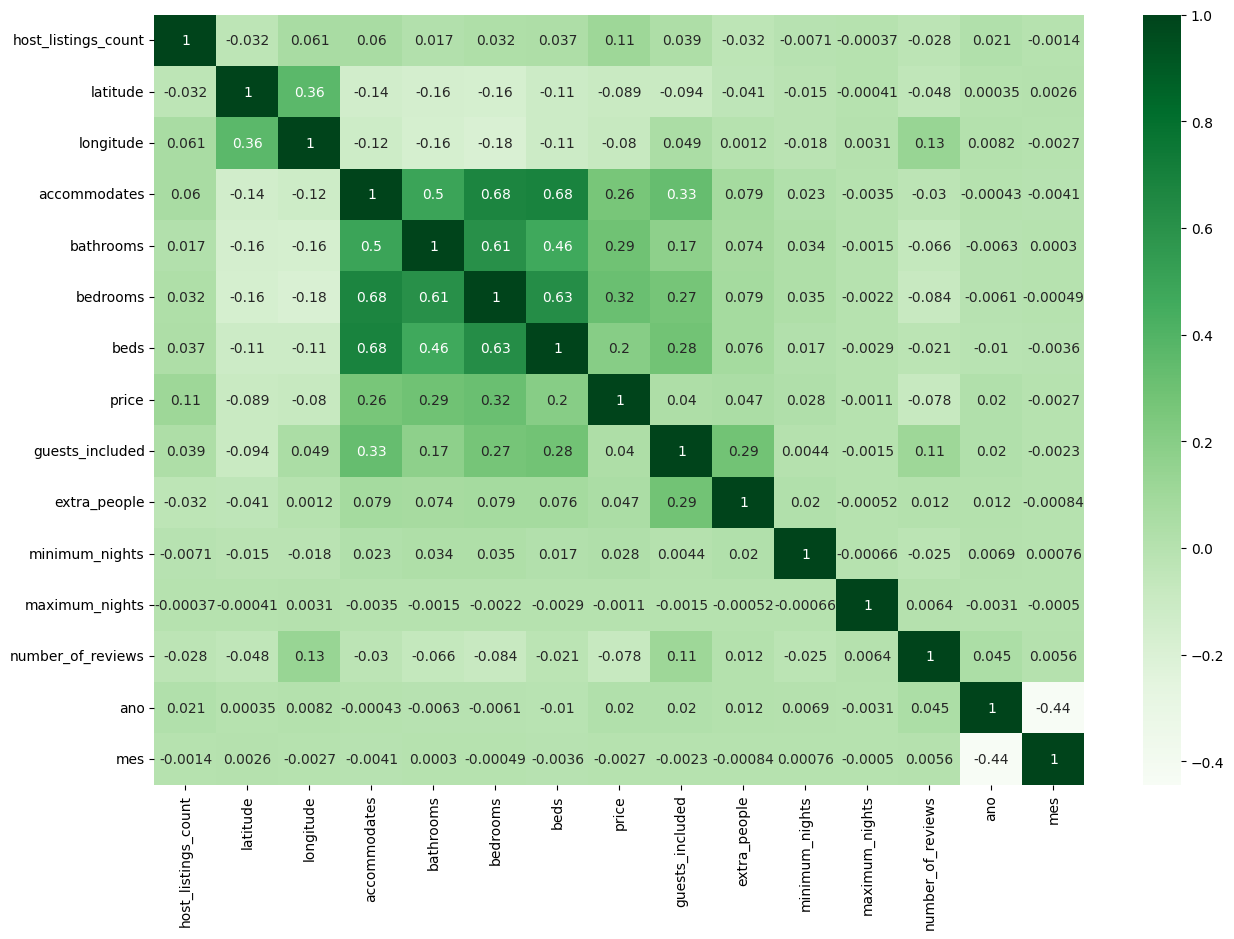

In [ ]:
# Primeiro passo, analisar as correla√ß√µes entre as colunas
#print(base_airbnb.corr())
#plt.figure(figsize=(15,5))
#sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
# Selecionar apenas as colunas num√©ricas
df_numerico = base_airbnb.select_dtypes(include=['number'])

# Gerar heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_numerico.corr(), annot=True, cmap='Greens')
plt.show()

# Analisando as correla√ß√µes, pode-se avaliar que n√£o existe nenhuma correla√ß√ßao direta muito forte, que poderiam ter o mesmo comportamento. Nesse caso, podemos partir para avalia√ß√£o de cada um dos itens isoladamente

## Defini√ß√£o das fun√ß√µes para an√°lise de outliers
Para definir os limites superior e inferior usaremos como regra, valores abaixo de Q1 - 1.5 x Amplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1

In [9]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude    #Limite inferior e limite superior

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(10, 3))
    sns.histplot(coluna, kde=True)

def grafico_barra(coluna):
    plt.figure(figsize=(10, 3))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))


## An√°lise da Coluna Price
(n√∫mero cont√≠nuo)

In [ ]:
base_airbnb['price'].describe()

count      636243
unique       5766
top       $298.00
freq        10855
Name: price, dtype: object

In [ ]:
print((base_airbnb['price'] == 0).sum())

154


In [ ]:
# Excluindo as linhas com valores de alugue igual a 0
base_airbnb = base_airbnb[base_airbnb['price'] != 0]

(np.float64(-524.0), np.float64(1276.0))


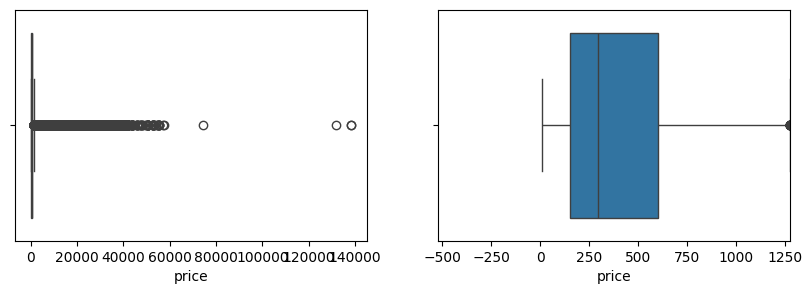

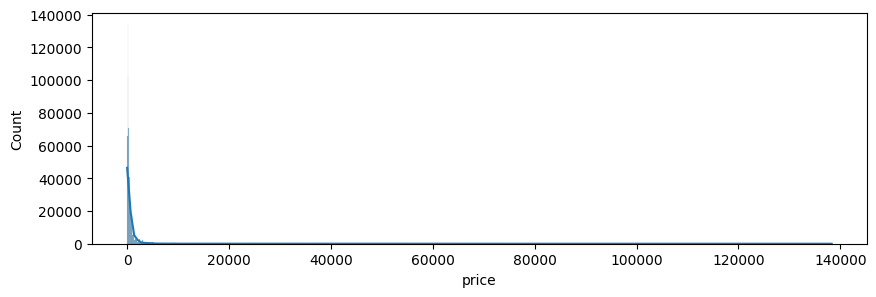

In [ ]:
print(limites(base_airbnb['price']))
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

In [10]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas.'.format(linhas_removidas))

62718 linhas removidas.


In [ ]:
base_airbnb['price'].describe()

count    573371.000000
mean        353.934326
std         283.969177
min          12.000000
25%         149.000000
50%         251.000000
75%         491.000000
max        1276.000000
Name: price, dtype: float64

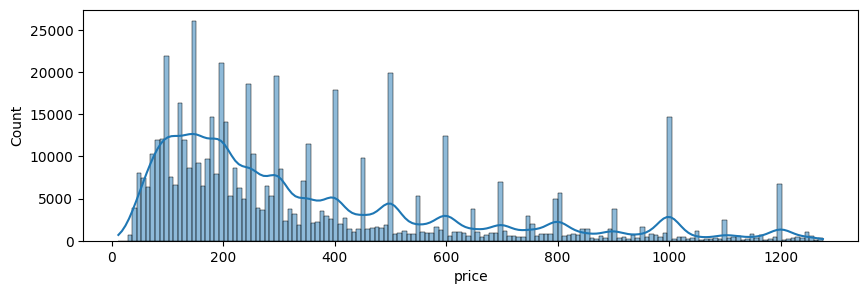

In [ ]:
# PRICE
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imoveis comuns, acretido que os valores acima do limite superior que √© de 1.2k os imoveis com aluguel acima desse valor (entende-se que s√£o imoveis de alto padr√£o) ser√£o excluidos do modelo. Considerando que o aluguel de imoveis de alto padr√£o levam em considera√ß√£o outras quest√µes.

## An√°lise da Coluna Extra People
(n√∫mero cont√≠nuo)

In [ ]:
base_airbnb['extra_people'].describe()

count    573371.000000
mean         38.807438
std          85.139275
min           0.000000
25%           0.000000
50%           0.000000
75%          50.000000
max        5631.000000
Name: extra_people, dtype: float64

(np.float64(-75.0), np.float64(125.0))


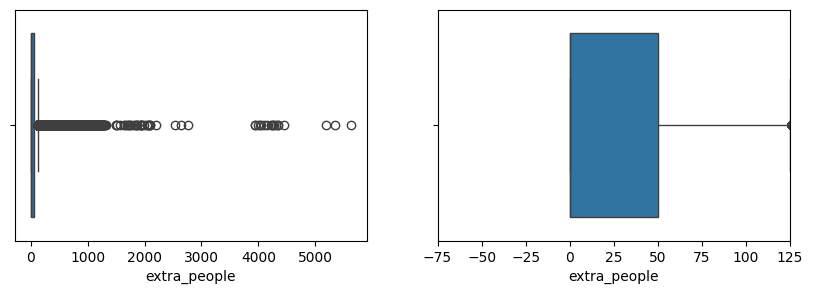

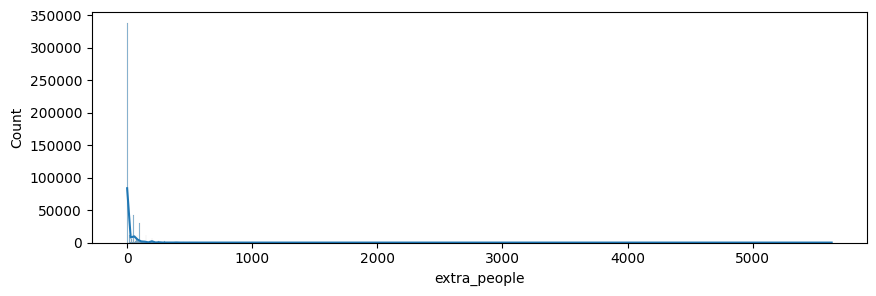

In [ ]:
print(limites(base_airbnb['extra_people']))
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])
# A grande maioria n√£o cobra ou cobra uma taxa menor de 100. Com essa configura√ß√£o, os que cobram mais de 100 est√£o sendo configurados como outlier. Inicialmente, irei retirar esses valores.

42291 linhas removidas.


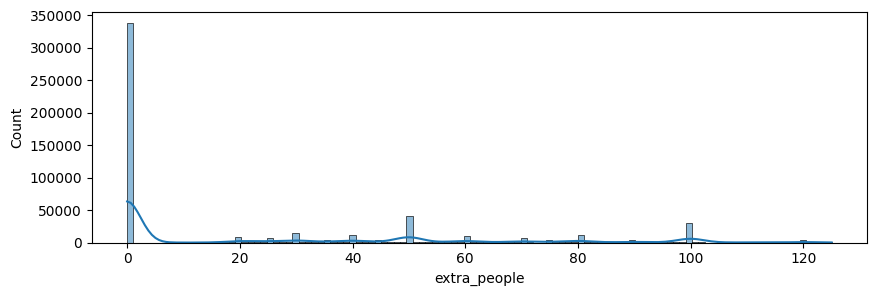

In [11]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas.'.format(linhas_removidas))
histograma(base_airbnb['extra_people'])

In [ ]:
base_airbnb['extra_people'].describe()

count    531084.000000
mean         21.998812
std          33.567440
min           0.000000
25%           0.000000
50%           0.000000
75%          46.000000
max         125.000000
Name: extra_people, dtype: float64

## An√°lise da coluna Host_listings-count
Essa coluna representa quantos an√∫ncios um mesmo anfitri√£o tem na plataforma do Airbnb

In [ ]:
base_airbnb['host_listings_count'].describe()

count    531084.000000
mean          8.431743
std          35.603456
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1321.000000
Name: host_listings_count, dtype: float64

(np.float64(-2.0), np.float64(6.0))


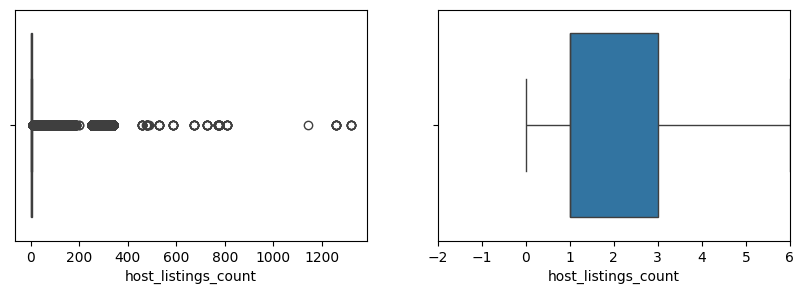

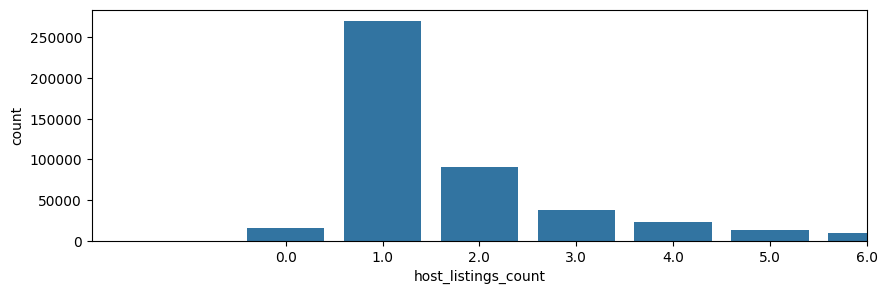

In [ ]:
print(limites(base_airbnb['host_listings_count']))
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [ ]:
base_airbnb['host_listings_count'].value_counts()

host_listings_count
1.0      270576
2.0       90712
3.0       37999
4.0       22513
0.0       15721
          ...  
329.0         1
114.0         1
161.0         1
473.0         1
336.0         1
Name: count, Length: 169, dtype: int64

In [12]:
# Podemos exluir os outliers porque parao objetivo do projeto um host com mais de seis im√≥veis no airbnb n√£o √© o publico do sistema. Suponho que esses host sejam imobiliarias ou profissionais que gerenciam imoveis no airbnb.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas.'.format(linhas_removidas))

70782 linhas removidas.


## An√°lise da coluna accommodates

In [ ]:
base_airbnb['accommodates'].describe()

count    460419.00000
mean          3.74720
std           2.07509
min           1.00000
25%           2.00000
50%           4.00000
75%           5.00000
max          16.00000
Name: accommodates, dtype: float64

(np.float64(-2.5), np.float64(9.5))


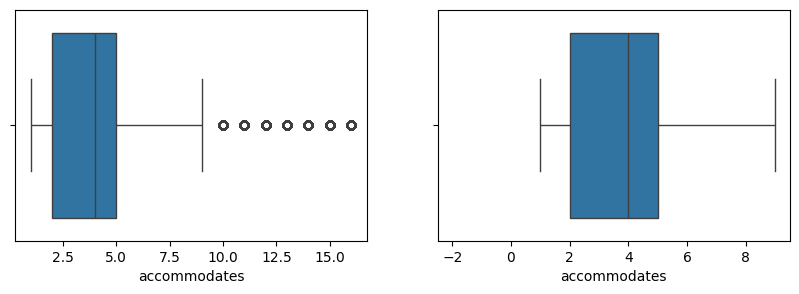

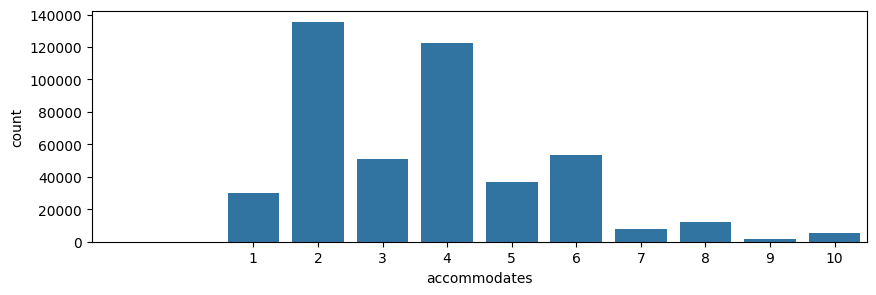

In [ ]:
print(limites(base_airbnb['accommodates']))
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas.'.format(linhas_removidas))

9282 linhas removidas.


## An√°lise da coluna bathrooms

In [ ]:
base_airbnb['bathrooms'].describe()

count    451137.000000
mean          1.474758
std           0.706924
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          22.000000
Name: bathrooms, dtype: float64

(np.float64(-0.5), np.float64(3.5))


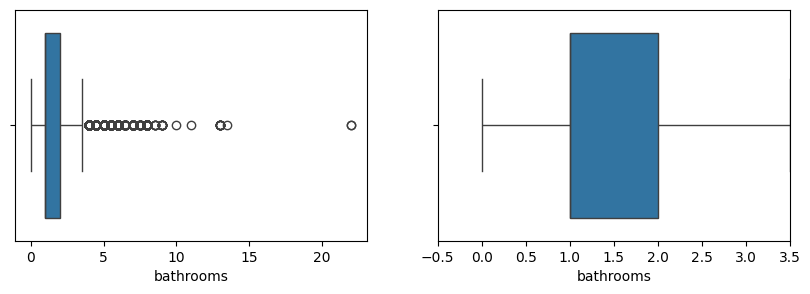

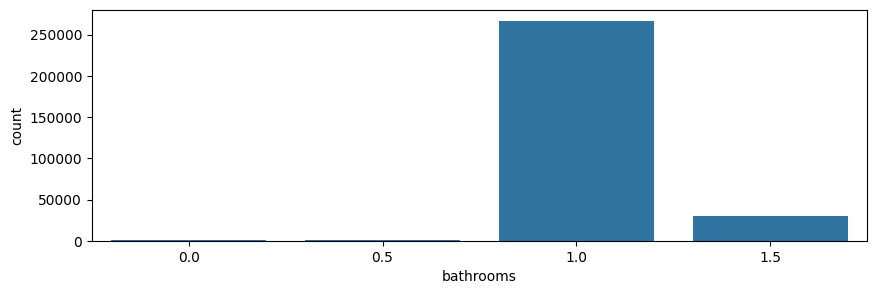

In [ ]:
print(limites(base_airbnb['bathrooms']))
diagrama_caixa(base_airbnb['bathrooms'])
grafico_barra(base_airbnb['bathrooms'])

In [ ]:
base_airbnb['bathrooms'].value_counts()

bathrooms
1.0     266903
2.0     107959
1.5      29578
3.0      23764
2.5      13904
3.5       2935
4.0       2826
0.0        868
4.5        690
5.0        571
0.5        519
8.0        143
6.0        141
5.5        116
7.0        110
6.5         50
7.5         32
13.0         9
9.0          9
8.5          5
22.0         2
13.5         1
10.0         1
11.0         1
Name: count, dtype: int64

In [14]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas.'.format(linhas_removidas))

4707 linhas removidas.


## An√°lise da coluna bedrooms

In [ ]:
base_airbnb['bedrooms'].describe()

count    446430.000000
mean          1.409047
std           0.788948
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: bedrooms, dtype: float64

(np.float64(-0.5), np.float64(3.5))


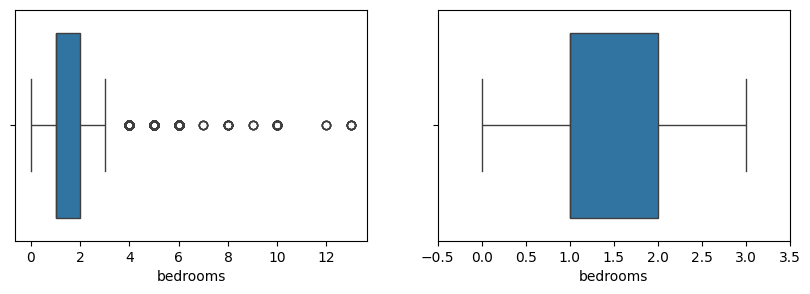

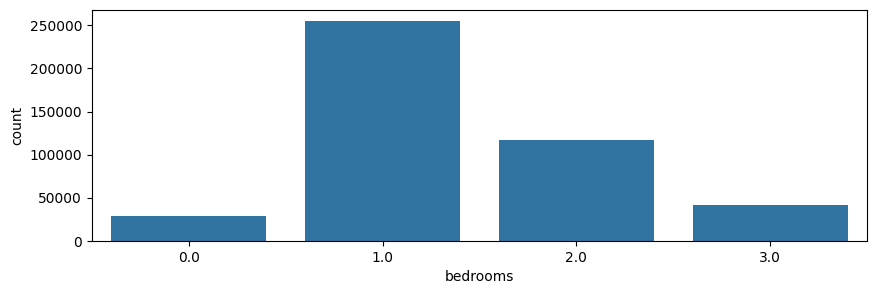

In [ ]:
print(limites(base_airbnb['bedrooms']))
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [15]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas.'.format(linhas_removidas))

3802 linhas removidas.


## An√°lise da coluna beds

In [ ]:
base_airbnb['beds'].describe()

count    442633.000000
mean          2.161757
std           1.348075
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          25.000000
Name: beds, dtype: float64

In [ ]:
base_airbnb['beds'].value_counts()

beds
1.0     170016
2.0     131679
3.0      73367
4.0      36900
5.0      14881
6.0       8279
0.0       3481
7.0       1819
8.0       1511
9.0        424
10.0       144
11.0        76
14.0        25
12.0        15
16.0        11
17.0         2
25.0         1
15.0         1
18.0         1
Name: count, dtype: int64

(np.float64(-2.0), np.float64(6.0))


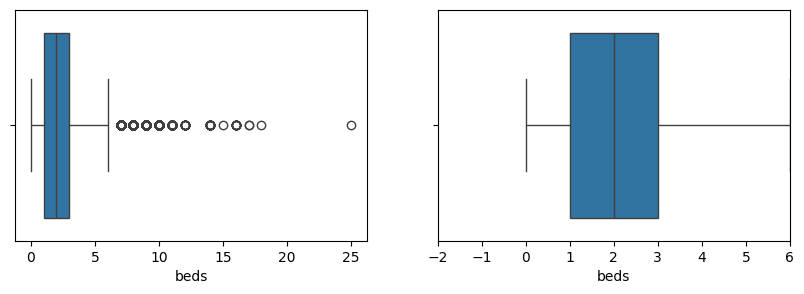

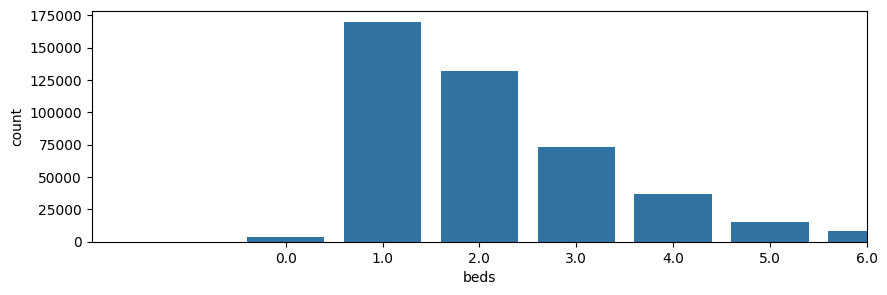

In [ ]:
print(limites(base_airbnb['beds']))
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas.'.format(linhas_removidas))

4030 linhas removidas.


## An√°lise da coluna guests_included

In [ ]:
base_airbnb['guests_included'].describe()

count    438603.000000
mean          1.480717
std           1.080579
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: guests_included, dtype: float64

In [ ]:
base_airbnb['guests_included'].value_counts()

guests_included
1     332377
2      59165
4      24057
3      11244
6       5739
5       4665
7        707
8        420
9         66
16        50
10        47
12        35
15        18
11         8
14         5
Name: count, dtype: int64

(np.float64(1.0), np.float64(1.0))


C:\Users\tamyc\AppData\Local\Temp\ipykernel_1872\1342871851.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\tamyc\AppData\Local\Temp\ipykernel_1872\1342871851.py:28: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(limites(coluna))


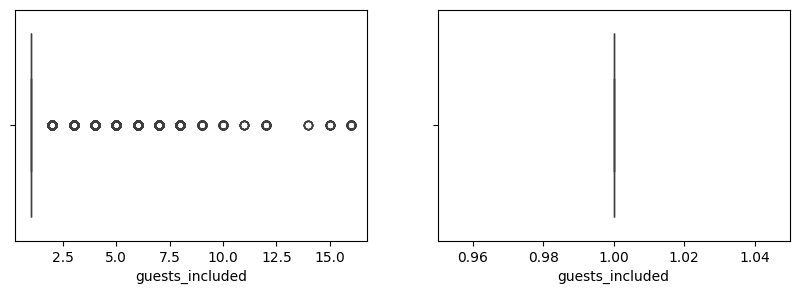

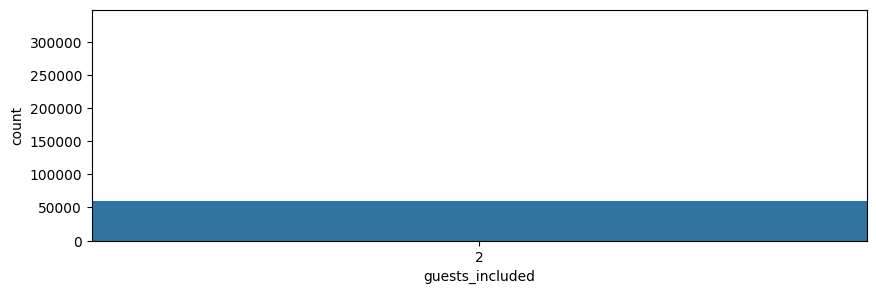

In [ ]:
print(limites(base_airbnb['guests_included']))
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])

In [17]:
# Esses n√∫meros nao est√£o apresentando confiabilidade pois n√£o faz sentido que mais da metade da base so permita uma pessoa. Por isso, essa coluna ser√° removida da an√°lise.
base_airbnb = base_airbnb.drop('guests_included', axis=1)

## An√°lise da coluna minimum_nights

In [ ]:
base_airbnb['minimum_nights'].describe()

count    438603.000000
mean          4.308096
std          19.025632
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1224.000000
Name: minimum_nights, dtype: float64

In [ ]:
base_airbnb['minimum_nights'].value_counts()

minimum_nights
1       127011
2       113872
3        81061
5        34169
4        28497
         ...  
1224         1
250          1
89           1
96           1
222          1
Name: count, Length: 80, dtype: int64

(np.float64(-3.5), np.float64(8.5))


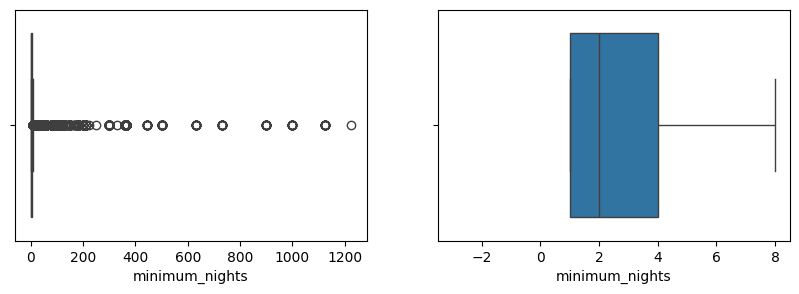

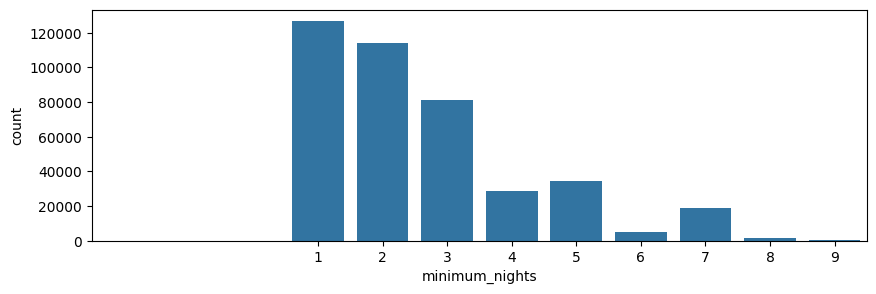

In [ ]:
print(limites(base_airbnb['minimum_nights']))
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [18]:
# A coluna de minimum_nights apresenta uma correla√ß√£o muito baixa com a coluna price, esses valores s√£o de 0,0.. e 0,00... Essa coluna poder√° ser retirada da an√°lise.
# Por enquanto, irei apenas retirar os outliers.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas.'.format(linhas_removidas))

28625 linhas removidas.


##An√°lise da coluna maximum_nights

In [ ]:
base_airbnb['maximum_nights'].describe()

count    4.099780e+05
mean     2.504524e+04
std      4.938726e+06
min      1.000000e+00
25%      3.000000e+01
50%      1.125000e+03
75%      1.125000e+03
max      1.000000e+09
Name: maximum_nights, dtype: float64

In [ ]:
base_airbnb['maximum_nights'].value_counts()

maximum_nights
1125    220619
30       45872
90       16790
15       15559
10       13034
         ...  
215          1
183          1
165          1
605          1
373          1
Name: count, Length: 245, dtype: int64

(np.float64(-1612.5), np.float64(2767.5))


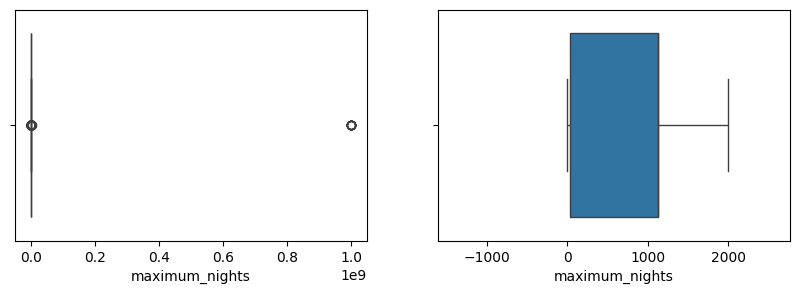

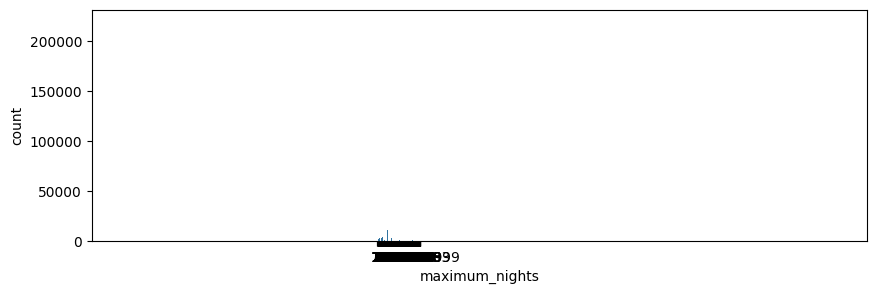

In [ ]:
print(limites(base_airbnb['maximum_nights']))
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [19]:
# A coluna maximum_nights apresenta uma correla√ß√£o muito baixa com a coluna price, esses valores s√£o de 0,0.. e 0,00... Al√©m disso, os valores parecem al√©at√≥rios, Por isso, essa coluna ser√° retirada.
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

In [ ]:
base_airbnb.shape

(409978, 21)

##An√°lise da coluna number_of_reviews

In [ ]:
base_airbnb['number_of_reviews'].describe()

count    409978.000000
mean          9.817466
std          25.137917
min           0.000000
25%           0.000000
50%           1.000000
75%           7.000000
max         392.000000
Name: number_of_reviews, dtype: float64

In [ ]:
base_airbnb['number_of_reviews'].value_counts()

number_of_reviews
0      158065
1       59431
2       31897
3       21522
4       15692
        ...  
364         1
309         1
322         1
359         1
349         1
Name: count, Length: 363, dtype: int64

(np.float64(-10.5), np.float64(17.5))


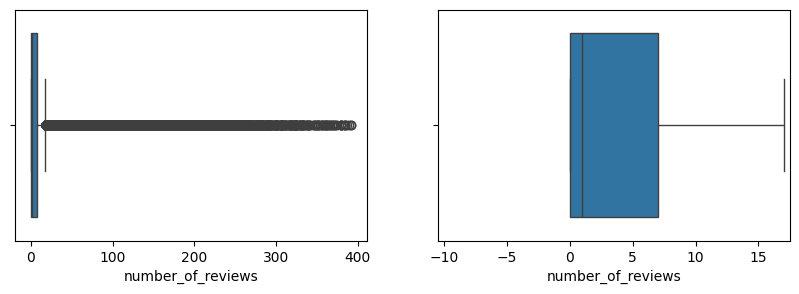

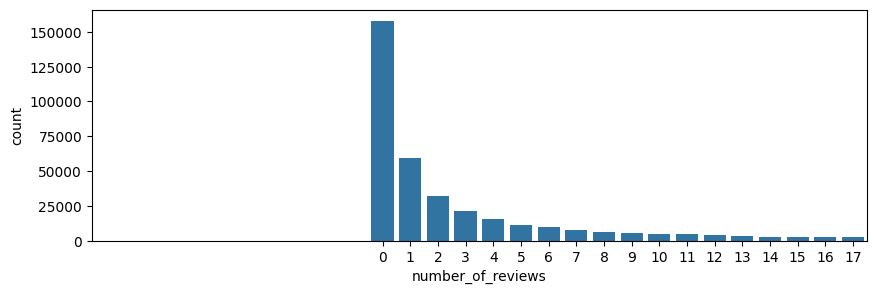

In [ ]:
print(limites(base_airbnb['number_of_reviews']))
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [20]:
# Nesse caso, a princ√≠pio, o numero de reviews n√£o tem correla√ß√£o com a forma√ß√£o do pre√ßo do aluguel e sim, com a decis√£o do usu√°rio de alugar o im√≥vel ou n√£o. Outra avalia√ß√£o e de que se o host possui um grande numero de reviews significa que o imovel dele e muito alugado e que o valor cobrado pelo aluguel est√° correto em rela√ß√£o ao que ele oferece e ao mercado. A principio, deixarei essa coluna ap√≥s a cria√ß√£o da ML avaliarei se essa coluna continuara ou n√£o.base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(410006, 20)

##An√°lise da coluna property_type

In [ ]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment                 320255
House                      35873
Condominium                21384
Serviced apartment          9199
Loft                        9046
Guest suite                 2775
Bed and breakfast           2108
Hostel                      1603
Guesthouse                  1576
Other                       1193
Villa                        913
Townhouse                    692
Aparthotel                   462
Tiny house                   417
Earth house                  368
Chalet                       352
Hotel                        309
Boutique hotel               308
Casa particular (Cuba)       219
Cottage                      184
Bungalow                     161
Cabin                        104
Nature lodge                  94
Treehouse                     55
Island                        46
Boat                          42
Castle                        36
Hut                           30
Campsite                      28
Dorm                         

In [21]:
# Todos os tipos de imoveis abaixo de 100 ser√£o classificados como Other

tabela_tipos_imovel = base_airbnb['property_type'].value_counts()
colunas_agrupadas = []

for tipo in tabela_tipos_imovel.index:
    if tabela_tipos_imovel[tipo] <= 2800:
        colunas_agrupadas.append(tipo)
#print(colunas_agrupadas)
for tipo in colunas_agrupadas:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Other'

In [ ]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment             320255
House                  35873
Condominium            21384
Other                  14221
Serviced apartment      9199
Loft                    9046
Name: count, dtype: int64


##An√°lise da coluna room_type

room_type
Entire home/apt    264258
Private room       136621
Shared room          8132
Hotel room            967
Name: count, dtype: int64


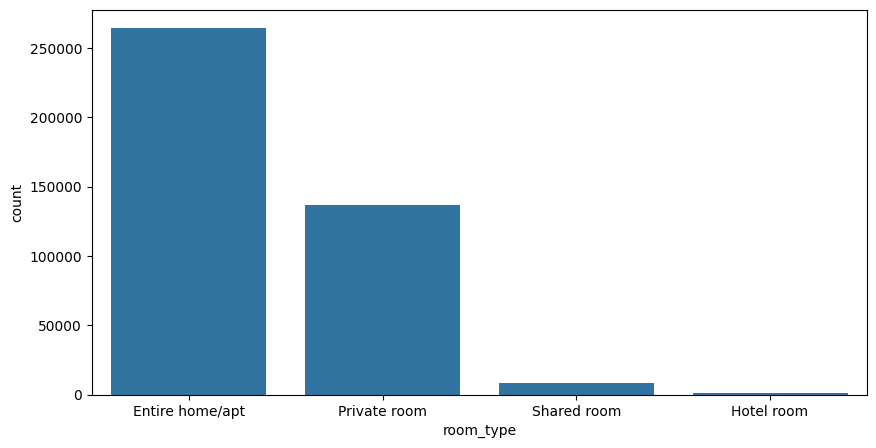

In [ ]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='room_type', data=base_airbnb)

Em tipo de quarto, n√£o precisamos fazer nada, ele j√° parece estar bem distribu√≠do

## An√°lise da coluna bed_type

bed_type
Real Bed         402588
Pull-out Sofa      5279
Futon              1045
Airbed              744
Couch               322
Name: count, dtype: int64


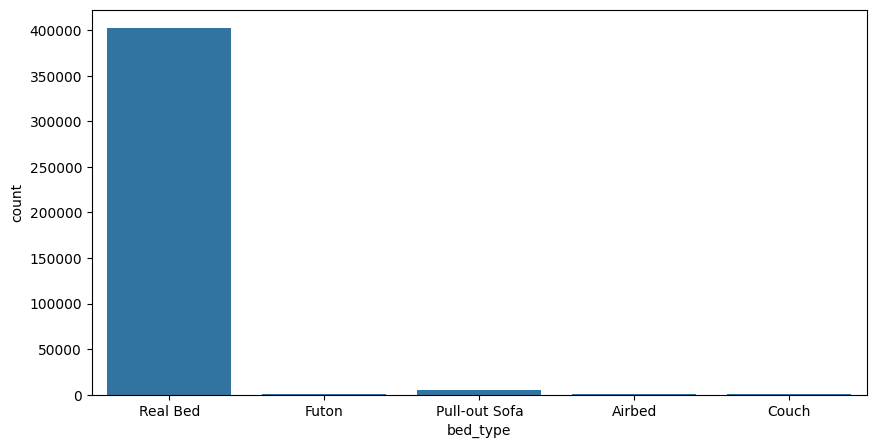

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)

In [22]:
# Agrupamentos de outros tipo de cama

tabela_tipos_cama = base_airbnb['bed_type'].value_counts()
colunas_agrupadas = []

for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] <= 10000:
        colunas_agrupadas.append(tipo)
#print(colunas_agrupadas)
for tipo in colunas_agrupadas:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Other_bed'

bed_type
Real Bed     402588
Other_bed      7390
Name: count, dtype: int64


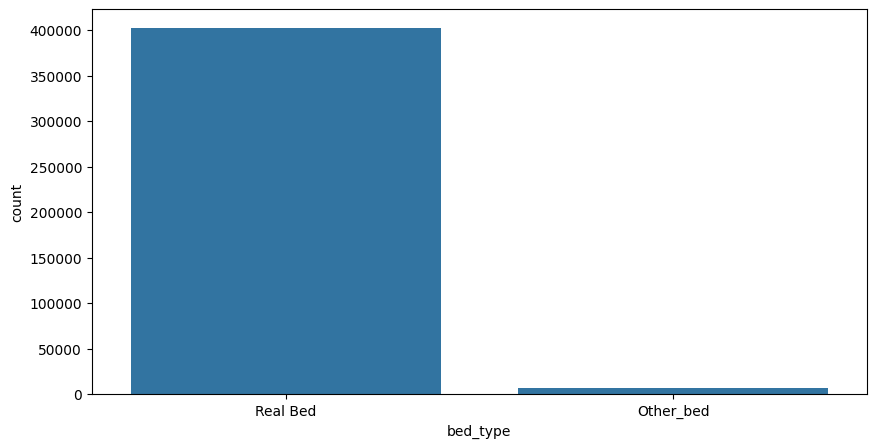

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)

## An√°lise da coluna cancellation_policy

cancellation_policy
flexible                       180340
strict_14_with_grace_period    148684
moderate                        80786
super_strict_60                   125
strict                             23
super_strict_30                    20
Name: count, dtype: int64


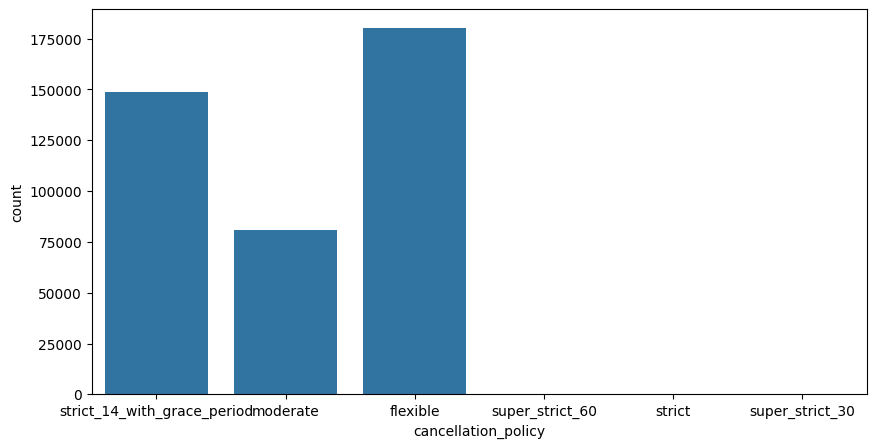

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)

cancellation_policy
flexible                       180340
strict_14_with_grace_period    148684
moderate                        80786
super_strict_60                   125
strict                             23
super_strict_30                    20
Name: count, dtype: int64


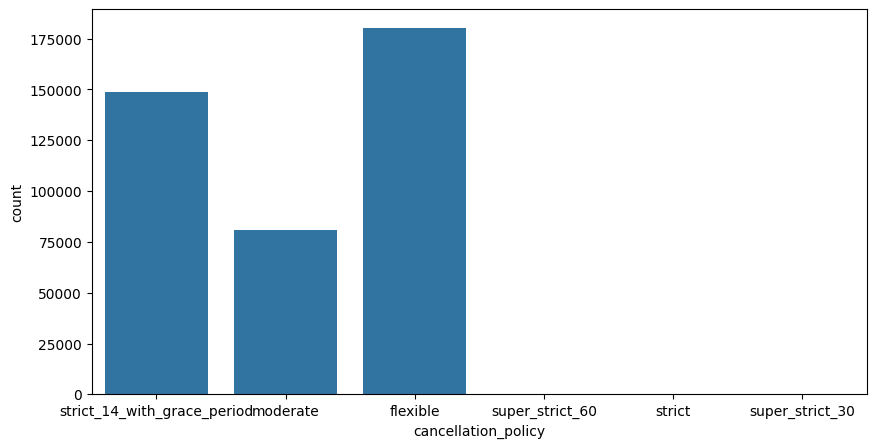

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)

In [23]:
# Agrupando strict, super_strict_30 e super_strict_60

tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

['super_strict_60', 'strict', 'super_strict_30']


In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())

cancellation_policy
flexible                       180340
strict_14_with_grace_period    148684
moderate                        80786
strict                            168
Name: count, dtype: int64


## An√°lise da coluna amenities

In [ ]:
print(base_airbnb['amenities'].value_counts())

amenities
{}                                                                                                                                   3745
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom",Washer}                           209
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom","Family/kid friendly",Washer}     157
{"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                           142
{"Smoking allowed","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                         131
                                                                                                                                     ... 
{TV,Wifi,"Air conditioning",Kitchen,Elevator,"Fire extinguisher",Essentials,Hangers,"Hair dryer","Hot water"}                           1
{Wifi,Kitchen,Washer,Ess

In [24]:
# Como essa coluna apresenta uma listas de comididades de cada imovel, e n√£o possui um padr√£o. Para avlaiar essa coluna, irei contar quantas comodidades o imovel possui para avaliar se vai agregar no modelo.

print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


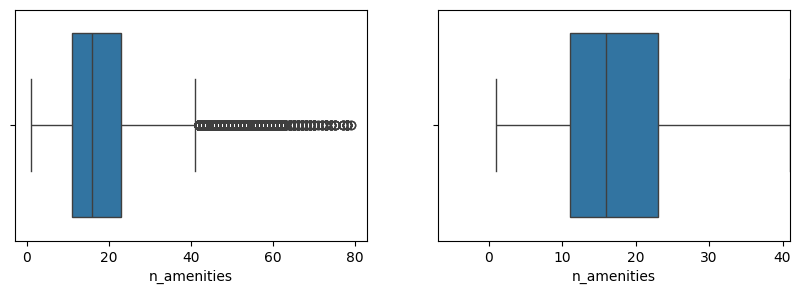

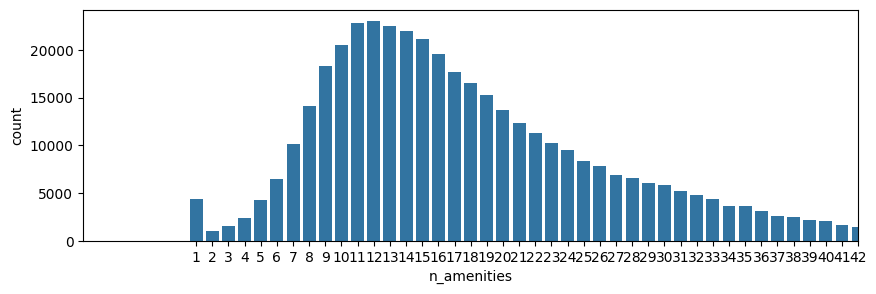

In [ ]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [25]:
# Retirando a coluna amenities
base_airbnb = base_airbnb.drop('amenities',axis=1 )

## An√°lise da coluna latitude e longitude

In [ ]:
# https://plotly.com/python/mapbox-to-maplibre/

# Amostra aleat√≥ria
amostra = base_airbnb.sample(n=50000, random_state=42)

# Centro do mapa
centro_mapa = {
    'lat': amostra['latitude'].mean(),
    'lon': amostra['longitude'].mean()
}

# Novo mapa com plotly express density_map (MapLibre)
mapa = px.density_map(
    amostra,
    lat='latitude',
    lon='longitude',
    z='price',
    radius=5,
    center=centro_mapa,
    zoom=10,
    map_style='carto-positron',  # equivalente ao stamen-terrain
    title="Mapa de Densidade de Pre√ßos do Airbnb"
)

mapa.show()


## Encoding

In [26]:
# Cria uma copia para realizar o encoding
base_airbnb_encoded = base_airbnb.copy()
display(base_airbnb_encoded.info())
display(base_airbnb_encoded.head())
base_airbnb_encoded.shape



<class 'pandas.core.frame.DataFrame'>
Index: 410006 entries, 0 to 639873
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         410006 non-null  object 
 1   host_listings_count       410006 non-null  float32
 2   latitude                  410006 non-null  float32
 3   longitude                 410006 non-null  float32
 4   property_type             410006 non-null  object 
 5   room_type                 410006 non-null  object 
 6   accommodates              410006 non-null  int32  
 7   bathrooms                 410006 non-null  float32
 8   bedrooms                  410006 non-null  float32
 9   beds                      410006 non-null  float32
 10  bed_type                  410006 non-null  object 
 11  price                     410006 non-null  float32
 12  extra_people              410006 non-null  float32
 13  minimum_nights            410006 non-null  int32 

None

host_is_superhost  host_listings_count   latitude  longitude property_type  \
0                 f                  2.0 -22.965919 -43.178959   Condominium   
1                 f                  3.0 -22.977119 -43.190449     Apartment   
2                 t                  1.0 -22.983021 -43.214272     Apartment   
3                 t                  1.0 -22.988159 -43.193588     Apartment   
4                 t                  1.0 -22.981270 -43.190460          Loft   

         room_type  accommodates  bathrooms  bedrooms  beds  bed_type  price  \
0  Entire home/apt             5        1.0       2.0   2.0  Real Bed  302.0   
1  Entire home/apt             3        1.0       1.0   2.0  Real Bed  159.0   
2  Entire home/apt             3        1.0       1.0   2.0  Real Bed  252.0   
3  Entire home/apt             3        1.5       1.0   2.0  Real Bed  350.0   
4  Entire home/apt             2        1.0       1.0   2.0  Real Bed  221.0   

   extra_people  minimum_nights instant_bookable is_business_travel_ready  \
0          58.0               5                t                        f   
1          45.0               4                f                        f   
2          39.0               2                t                        f   
3          58.0               2                f                        f   
4          80.0               3                t                        f   

           cancellation_policy   ano  mes  n_amenities  
0  strict_14_with_grace_period  2019    4           25  
1  strict_14_with_grace_period  2019    4           14  
2  strict_14_with_grace_period  2019    4           17  
3  strict_14_with_grace_period  2019    4           31  
4  strict_14_with_grace_period  2019    4           35

(410006, 20)

In [28]:
# Colunas com valores True ou False, vamos substituir True por 1 e False por 0.
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

for coluna in colunas_tf:
    base_airbnb.loc[base_airbnb_encoded[coluna]=='t', coluna] = 1
    base_airbnb.loc[base_airbnb_encoded[coluna]=='f', coluna] = 0

In [29]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

# Faz o encoding de todas as colunas categ√≥ricas de uma vez
base_airbnb_encoded = pd.get_dummies(base_airbnb, columns=colunas_categorias, drop_first=False)

# Agora fa√ßa o mapeamento das strings booleanas, etc.
mapa_binario = {'t': 1, 'f': 0, 'yes': 1, 'no': 0, 'True': 1, 'False': 0}

for col in base_airbnb_encoded.columns:
    if base_airbnb_encoded[col].dtype == 'object':
        base_airbnb_encoded[col] = base_airbnb_encoded[col].map(mapa_binario).fillna(base_airbnb_encoded[col])

# Converte booleanos para int32
for col in base_airbnb_encoded.select_dtypes(include='bool').columns:
    base_airbnb_encoded[col] = base_airbnb_encoded[col].astype('int32')

# Substitui NaN por 0
base_airbnb_encoded = base_airbnb_encoded.fillna(0)

# Converte float64 para float32 e int64 para int32
for col in base_airbnb_encoded.columns:
    if base_airbnb_encoded[col].dtype == 'float64':
        base_airbnb_encoded[col] = base_airbnb_encoded[col].astype('float32')
    elif base_airbnb_encoded[col].dtype == 'int64':
        base_airbnb_encoded[col] = base_airbnb_encoded[col].astype('int32')

display(base_airbnb_encoded.info())
display(base_airbnb_encoded.head())
base_airbnb_encoded.shape



<class 'pandas.core.frame.DataFrame'>
Index: 410006 entries, 0 to 639873
Data columns (total 32 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   host_is_superhost                                410006 non-null  int32  
 1   host_listings_count                              410006 non-null  float32
 2   latitude                                         410006 non-null  float32
 3   longitude                                        410006 non-null  float32
 4   accommodates                                     410006 non-null  int32  
 5   bathrooms                                        410006 non-null  float32
 6   bedrooms                                         410006 non-null  float32
 7   beds                                             410006 non-null  float32
 8   price                                            410006 non-null  float32
 9   extra_people        

None

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
0                  0                  2.0 -22.965919 -43.178959             5   
1                  0                  3.0 -22.977119 -43.190449             3   
2                  1                  1.0 -22.983021 -43.214272             3   
3                  1                  1.0 -22.988159 -43.193588             3   
4                  1                  1.0 -22.981270 -43.190460             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
0        1.0       2.0   2.0  302.0          58.0  ...   
1        1.0       1.0   2.0  159.0          45.0  ...   
2        1.0       1.0   2.0  252.0          39.0  ...   
3        1.5       1.0   2.0  350.0          58.0  ...   
4        1.0       1.0   2.0  221.0          80.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
0                          1                     0                       0   
1                          1                     0                       0   
2                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   

   room_type_Shared room  bed_type_Other_bed  bed_type_Real Bed  \
0                      0                   0                  1   
1                      0                   0                  1   
2                      0                   0                  1   
3                      0                   0                  1   
4                      0                   0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
0                           0                                                1  
1                           0                                                1  
2                           0                                                1  
3                           0                                                1  
4                           0                                                1  

[5 rows x 32 columns]

(410006, 32)

### Modelo de Previs√£o
- M√©tricas de Avalia√ß√£o

Vamos usar aqui o R¬≤ que vai nos dizer o qu√£o bem o nosso modelo consegue explicar o pre√ßo. Isso seria um √≥timo par√¢metro para ver o qu√£o bom √© nosso modelo.
-> Quanto mais pr√≥ximo de 100%, melhor

Vou calcular tamb√©m o Erro Quadr√°tico M√©dio, que vai mostrar para gente o quanto o nosso modelo est√° errando.
-> Quanto menor for o erro, melhor

In [30]:
# Fun√ß√£o de avalia√ß√£o para todos os modelos
def avaliar_modelo(nome_modelo, modelo, X_train, y_train, X_test, y_test):
    inicio = time.time()
    modelo.fit(X_train, y_train)
    fim = time.time()

    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print(f"\n--- Avalia√ß√£o do Modelo: {nome_modelo} ---")
    print(f"Tempo de execu√ß√£o: {fim - inicio:.2f} segundos")
    print(f"\n--- Desempenho no TREINO ---")
    print(f"R¬≤ (Treino): {r2_score(y_train, y_pred_train) * 100:.2f}%")
    print(f"RMSE (Treino): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

    print(f"\n--- Desempenho no TESTE ---")
    print(f"R¬≤ (Teste): {r2_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"RMSE (Teste): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")

- Escolha dos Modelos a Serem Testados
    1. RandomForestRegressor
    2. LinearRegression
    3. Extra Tree
    4. GradientBoostingRegressor
    5. XGBoost
    6. LightGBM
    
Esses s√£o alguns dos modelos que existem para fazer previs√£o de valores num√©ricos (o que chamamos de regress√£o). Estamos querendo calcular o pre√ßo, portanto, queremos prever um valor num√©rico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou at√© centenas de modelos diferentes. A medida com que voc√™ for aprendendo mais e mais sobre Ci√™ncia de Dados, voc√™ vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situa√ß√£o.

Mas na d√∫vida, esses 3 modelos que usamos aqui s√£o bem bons para muitos problemas de Regress√£o.

In [31]:
# Cria dataframe para teste dos modelos
base_airbnb_modelo = base_airbnb_encoded.copy()

# Separa x e y
y = base_airbnb_modelo['price']
X = base_airbnb_modelo.drop('price', axis=1)

# Separa√ß√£o da Bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

## 1. RandomForestRegressor

In [ ]:
# Executando o modelo RandonForest
modelo_rf = RandomForestRegressor()
avaliar_modelo("RandomForestRegressor", modelo_rf, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: RandomForestRegressor ---
Tempo de execu√ß√£o: 476.61 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 99.42%
RMSE (Treino): 19.97

--- Desempenho no TESTE ---
R¬≤ (Teste): 95.95%
RMSE (Teste): 52.83


**M√©trica	Treino	Teste**
**R¬≤	    99.42%	95.95%**
**RMSE	19.97	52.83**
**Tempo Execu√ß√£o	~477 segundos**

Pontos positivos:
- Alto R¬≤ no teste (95.95%) ‚Üí O modelo consegue explicar quase 96% da vari√¢ncia dos dados de teste.
- Baixo RMSE no teste (52.83) ‚Üí O erro m√©dio √© relativamente baixo, o que mostra boa capacidade preditiva.
- Melhor desempenho entre os modelos testados at√© agora, inclusive superando XGBoost e LightGBM.
Pontos negativos:
- O R¬≤ no treino est√° alt√≠ssimo (99.42%), quase perfeito.
- O RMSE no treino √© muito menor que no teste (19.97 vs 52.83).
- Esse gap entre treino e teste indica que o modelo pode estar memorizar os dados de treino em vez de generalizar para novos dados.


## 2. LinearRegression

In [ ]:
# Executando o modelo LinearRegression
modelo_lr = LinearRegression()
avaliar_modelo("LinearRegression", modelo_lr, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: LinearRegression ---
Tempo de execu√ß√£o: 1.55 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 32.04%
RMSE (Treino): 215.57

--- Desempenho no TESTE ---
R¬≤ (Teste): 31.97%
RMSE (Teste): 216.46


In [ ]:
O desempenho do LinearREgression foi bem inferior ao esperado.

## 3. ExtraTreeRegressor

In [32]:
# Executando o modelo ExtraTreesRegressor
modelo_et = ExtraTreesRegressor()
avaliar_modelo("ExtraTreesRegressor", modelo_et, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: ExtraTreesRegressor ---
Tempo de execu√ß√£o: 276.44 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 100.00%
RMSE (Treino): 0.09

--- Desempenho no TESTE ---
R¬≤ (Teste): 96.31%
RMSE (Teste): 50.42


**M√©trica	Treino	Teste**
**R¬≤	    100.00%	96.31%**
**RMSE	0.09	50.42**
**Tempo Execu√ß√£o	~276 segundos**

Ponto Positivos:
- R¬≤ no teste (96.31%): Excelente! Explica mais de 96% da vari√¢ncia dos dados n√£o vistos.
- RMSE no teste (50.42): Melhor que o RandomForest anterior (52.83), ent√£o o erro de previs√£o caiu.
- Tempo de execu√ß√£o menor que o RandomForest padr√£o (~276s vs ~477s).

Pontos Negativos:
- Sinais cr√≠ticos de Overfitting
- R¬≤ no treino = 100% e RMSE = 0.09 ‚Üí O modelo memoriza os dados de treino quase perfeitamente.
- Gap muito grande entre treino e teste, mesmo com bom R¬≤ no teste.

In [48]:
# Teste do modelo redefinido
modelo_et_redefinido = ExtraTreesRegressor(
    n_estimators=200,       # Pode manter ou at√© diminuir um pouco
    max_depth=20,           # <<< MUITO IMPORTANTE
    min_samples_leaf=5,    # <<< MUITO IMPORTANTE
    n_jobs=-1,              # Para usar todos os processadores
    random_state=42         # Para reprodutibilidade
)

avaliar_modelo("ExtraTreesRegressor", modelo_et_redefinido, X_train, y_train, X_test, y_test)



--- Avalia√ß√£o do Modelo: ExtraTreesRegressor ---
Tempo de execu√ß√£o: 194.33 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 84.75%
RMSE (Treino): 102.13

--- Desempenho no TESTE ---
R¬≤ (Teste): 81.62%
RMSE (Teste): 112.50


In [ ]:
An√°lise dos Resultados

Resultado Anterior (Overfitting):
**-R¬≤ Treino: 100%**
**-R¬≤ Teste: 96.29%**

Resultado Atual (Regularizado):
**-R¬≤ Treino: 84.75%**
**-R¬≤ Teste: 81.62%**

Diferen√ßa: 3.13%

O Ponto Positivo: Overfitting Resolvido
A diferen√ßa entre o desempenho no treino e no teste agora √© pequena (apenas 3.13%). Isso mostra que o seu modelo regularizado √© robusto e generaliza bem o que aprendeu para dados novos. O modelo n√£o est√° mais "memorizando" o treino.

O overfiting acabou por√©m, podemos melhorar o desempenho.

## 4. GradientBoostingRegressor

In [ ]:
# Executando o modelo GradientBoostingRegressor
modelo_gb = GradientBoostingRegressor()
avaliar_modelo("GradientBoostingRegressor", modelo_gb, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: GradientBoostingRegressor ---
Tempo de execu√ß√£o: 84.37 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 41.90%
RMSE (Treino): 199.32

--- Desempenho no TESTE ---
R¬≤ (Teste): 41.61%
RMSE (Teste): 200.55


M√©trica	Treino	Teste	An√°lise
**R¬≤	41.90%	41.61%	Ruim (baixa explica√ß√£o da vari√¢ncia)**
**RMSE	199.32	200.55	Erro alto**
**Tempo	84.37 segundos	‚Äî	Razo√°vel, mas n√£o justifica o desempenho**

Pontos Positivos:
- Desempenho bom mas n√£o justifica.

Pontos Negativos:
- O modelo est√° subajustado (underfitting):
- R¬≤ abaixo de 50% indica que ele n√£o est√° capturando bem os padr√µes nos dados.
- Isso vale tanto no treino quanto no teste ‚Äî ou seja, ele est√° com baixa capacidade preditiva geral.
- O RMSE est√° muito alto (200), pior que os outros modelos que voc√™ testou (por exemplo, ExtraTrees com RMSE de 50‚Äì110).

In [49]:
# Refinando os par√¢metros para buscar um desempenho melhor
modelo_gb_redefinido = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=3,
    random_state=42
)
avaliar_modelo("GradientBoostingRegressor", modelo_gb_redefinido, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: GradientBoostingRegressor ---
Tempo de execu√ß√£o: 241.07 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 51.33%
RMSE (Treino): 182.44

--- Desempenho no TESTE ---
R¬≤ (Teste): 50.18%
RMSE (Teste): 185.25


M√©trica	        Modelo Redefinido	Primeiro Modelo
**Tempo Execu√ß√£o	241.07 s	    84.37 s**
**R¬≤ (Treino)	    51.33%	        41.90%**
**RMSE (Treino)	    182.44          199.32**
**R¬≤ (Teste)	    50.18%	        41.61%**
**RMSE (Teste)	    185.25	        200.55**

Pontos Positivos:
- Desempenho melhor
- Generaliza√ß√£o mais forte, pois melhora tanto o treino quanto o teste.

Pontos negativos:
- Tanto o erro quanto a capacidade de explica√ß√£o do modelo s√£o mais baixos.
- Pode ter sofrido de underfitting: o modelo est√° muito simples para capturar os padr√µes dos dados.

Ainda n√£o √© um bom modelo para ser trabalhado.


## 5. XGBRegressor  

In [ ]:
# Exeutando o modelo XGRegressor
modelo_xgb = XGBRegressor()
avaliar_modelo("XGBoost", modelo_xgb, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: XGBoost ---
Tempo de execu√ß√£o: 3.54 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 59.71%
RMSE (Treino): 165.98

--- Desempenho no TESTE ---
R¬≤ (Teste): 57.75%
RMSE (Teste): 170.58


M√©trica	Treino	Teste	An√°lise
**R¬≤	    59.71%	57.75%	Regular, com espa√ßo para melhoria**
**RMSE	165.98	170.58	Erro ainda alto**
**Tempo exec.	‚è±Ô∏è 3.54s	‚Äî	Excelente! Muito r√°pido**

Pontos positivos:
- Sem overfitting: diferen√ßa pequena entre treino e teste.
- Boa generaliza√ß√£o para um modelo simples e leve.
- Execu√ß√£o extremamente r√°pida, ideal para itera√ß√£o e tuning.
- Melhor que GradientBoostingRegressor (que teve ~50% R¬≤ e RMSE > 180).

Pontos Negativos:
- Ainda n√£o competitivo com seus melhores modelos:
- ExtraTrees e RandomForest tiveram R¬≤ > 95% e RMSE < 60.
- Provavelmente est√° subajustado:
- Par√¢metros atuais n√£o permitem √† √°rvore aprender padr√µes mais profundos ou complexos.


In [ ]:
# Refinando os par√¢metros para buscar um desempenho melhor
modelo_xgb_redefinido = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=9,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=1,              # ajuda a evitar overfitting
    reg_alpha=0.1,        # L1 regularization
    reg_lambda=1,         # L2 regularization
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", modelo_xgb_redefinido, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: XGBoost ---
Tempo de execu√ß√£o: 36.63 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 79.74%
RMSE (Treino): 117.71

--- Desempenho no TESTE ---
R¬≤ (Teste): 76.58%
RMSE (Teste): 127.01


In [56]:
# Definindo o modelo base
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

# Espa√ßo de busca
param_distributions = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [5, 7, 9],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

# Busca com valida√ß√£o cruzada
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    scoring='r2',
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Executa a busca
# avaliar_modelo("XGBoost", v, X_train, y_train, X_test, y_test)
random_search.fit(X_train, y_train)

# Melhor modelo
print("Melhores par√¢metros:", random_search.best_params_)
melhor_xgb = random_search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Melhores par√¢metros: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}


In [ ]:
# MELHOR MODELO!

melhor_xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", melhor_xgb, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: XGBoost ---
Tempo de execu√ß√£o: 34.78 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 88.09%
RMSE (Treino): 90.26

--- Desempenho no TESTE ---
R¬≤ (Teste): 84.67%
RMSE (Teste): 102.76


#   **----MELHOR MODELO-----**

M√©trica	Treino	Teste
**R¬≤	88.09%	84.67%**
**RMSE	90.26	102.76**
**Gap de R¬≤	~3.4 p.p.	üîπ Pequeno**

Pontos Positivos:
- Alta performance geral: R¬≤ de 84.67% no teste mostra que o modelo explica bem a variabilidade dos pre√ßos.
- Erro absoluto moderado: RMSE de ~102 indica que, em m√©dia, o modelo erra o pre√ßo em ~R$102 ‚Äî o que pode ser aceit√°vel dependendo da escala do valor (price).
- Pouco overfitting: A diferen√ßa entre treino e teste √© pequena ‚Äî ou seja, o modelo generaliza bem.

## 6. LightGBM 

In [40]:
# 6. LightGBM
modelo_lgb = LGBMRegressor()

# Avaliar todos
avaliar_modelo("LightGBM", modelo_lgb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 307504, number of used features: 30
[LightGBM] [Info] Start training from score 319.407435

--- Avalia√ß√£o do Modelo: LightGBM ---
Tempo de execu√ß√£o: 5.87 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 50.03%
RMSE (Treino): 184.86

--- Desempenho no TESTE ---
R¬≤ (Teste): 49.20%
RMSE (Teste): 187.05


In [41]:
modelo_lgb = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=9,
    num_leaves=64,           # mais flex√≠vel
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

avaliar_modelo("LightGBM", modelo_lgb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 307504, number of used features: 30
[LightGBM] [Info] Start training from score 319.407435

--- Avalia√ß√£o do Modelo: LightGBM ---
Tempo de execu√ß√£o: 15.34 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 61.73%
RMSE (Treino): 161.76

--- Desempenho no TESTE ---
R¬≤ (Teste): 59.77%
RMSE (Teste): 166.45


## ** Compara√ß√£o entre os modelos**

Modelo	                    R¬≤ (Treino) RMSE (Treino)	R¬≤ (Teste)	RMSE (Teste)	Tempo (s)	Overfitting
**XGBoost (otimizado)	        88.09%	    90.26	        84.67%	    102.76	        34.78	    Baixo**
RandomForestRegressor	    99.42%	    19.97	        95.95%	    52.83	        476.61	    Moderado
ExtraTrees              	84.75%	    102.13	        81.62%	    112.50	        188.51	    Baixo
LightGBM                    61.73%	    161.76	        59.77%	    166.45	        15.34	    Baixo
GradientBoosting        	51.33%	    182.44	        50.18%	    185.25	        241.07	    Baixo

### An√°lise do Melhor Modelo

In [40]:
# Avaliando a importancia de cada uma das features no model0

# Seus dados originais
importancias = modelo_et.feature_importances_
nomes_colunas = X_train.columns

# Criando uma S√©rie no Pandas com as import√¢ncias
importancia_features_df = pd.Series(importancias, index=nomes_colunas)

# Ordenando da mais importante para a menos importante
importancia_features_df = importancia_features_df.sort_values(ascending=False)

# Imprimindo o resultado formatado
for coluna, importancia in importancia_features_df.items():
    print(f"{coluna:<25} {importancia:.2%}") # '<25' alinha o texto √† esquerda


bedrooms                  11.17%
latitude                  10.36%
longitude                 10.13%
extra_people              8.97%
n_amenities               8.78%
accommodates              7.44%
bathrooms                 6.79%
minimum_nights            6.69%
room_type_Entire home/apt 6.06%
beds                      5.22%
host_listings_count       4.23%
instant_bookable          2.22%
cancellation_policy_flexible 1.79%
host_is_superhost         1.64%
property_type_Apartment   1.32%
cancellation_policy_strict_14_with_grace_period 1.24%
cancellation_policy_moderate 1.04%
ano                       0.97%
property_type_House       0.72%
property_type_Condominium 0.59%
mes                       0.56%
room_type_Private room    0.40%
property_type_Other       0.37%
property_type_Serviced apartment 0.28%
bed_type_Other_bed        0.26%
bed_type_Real Bed         0.25%
property_type_Loft        0.24%
room_type_Shared room     0.19%
room_type_Hotel room      0.04%
cancellation_policy_strict 0.04%
i

##An√°lise das features

**Vari√°veis mais importantes (acima de 8%)**
Vari√°vel	    Import√¢ncia (%)	Interpreta√ß√£o
bedrooms	    10.96%	    O n√∫mero de quartos √© o fator mais relevante. Indica forte correla√ß√£o com a capacidade, conforto e pre√ßo da acomoda√ß√£o.
latitude	    10.38%	    Localiza√ß√£o geogr√°fica tem papel central na precifica√ß√£o. Regi√µes mais valorizadas geram pre√ßos maiores.
longitude	    10.08%	    Complementa a latitude para determinar a exata localiza√ß√£o do im√≥vel.
n_amenities	    8.82%	    N√∫mero de comodidades dispon√≠veis afeta a atratividade e valor percebido.
extra_people	8.73%	    Pol√≠tica de pre√ßo por h√≥spedes extras influencia bastante o valor final.

**Essas 5 vari√°veis respondem por cerca de 49% da import√¢ncia total do modelo, com √™nfase clara em localiza√ß√£o, estrutura f√≠sica e pol√≠ticas de hospedagem.**

**Import√¢ncia moderada (entre 5% e 8%)**
Vari√°vel	                Import√¢ncia (%)	Interpreta√ß√£o
accommodates	            7.31%	        Capacidade de h√≥spedes tamb√©m tem forte impacto. Naturalmente ligada a bedrooms e beds.
bathrooms	                6.95%	        Mais banheiros agregam conforto, principalmente para grupos.
minimum_nights	            6.69%	        Regras de estadia m√≠nima podem afastar ou atrair certos perfis.
room_type_Entire home/apt	6.35%	        Oferecer o im√≥vel inteiro √© altamente valorizado pelos usu√°rios.
beds	                    5.26%	        Quantidade de camas √© importante, mas menos que bedrooms e accommodates.

**Essas vari√°veis refor√ßam a l√≥gica de que capacidade, conforto e flexibilidade s√£o grandes impulsionadores de valor.**

**Import√¢ncia baixa (entre 1% e 5%)**
Vari√°vel	                                    Import√¢ncia (%)	Interpreta√ß√£o
host_listings_count	                            4.23%	    Hosts com muitos im√≥veis podem adotar estrat√©gias de pre√ßo diferenciadas.
instant_bookable	                            2.25%	    Facilidade de reserva tem influ√™ncia moderada.
cancellation_policy_flexible	                1.79%	    Pol√≠ticas mais flex√≠veis podem tornar o im√≥vel mais atraente.
host_is_superhost	                            1.68%	    Ser um superhost tem leve influ√™ncia no modelo.
property_type_Apartment	                        1.31%	    Tipo do im√≥vel afeta o valor, mas n√£o √© o mais determinante.
cancellation_policy_strict_14_with_grace_period	1.25%	    Pol√≠ticas r√≠gidas tendem a afastar h√≥spedes, o que reduz atratividade.
cancellation_policy_moderate	                1.05%	    Parecido com o anterior. Baixa influ√™ncia.

**Aqui entram caracter√≠sticas mais subjetivas e relacionadas √† experi√™ncia do h√≥spede.**

**Import√¢ncia muito baixa (abaixo de 1%)**
Vari√°vel	                                                Import√¢ncia (%)	Observa√ß√£o
ano, mes	                                                0.98%, 0.55%	Sazonalidade e varia√ß√£o ao longo do tempo t√™m influ√™ncia pequena.
property_type_House, Condominium, Other, Serviced apartment	0.72% a 0.30%	Diferencia√ß√£o por tipo de im√≥vel tem pouco peso.
room_type_Private room	                                    0.37%	        Menos valorizado que aluguel de im√≥vel inteiro.
bed_type_Real Bed	                                        0.26%	        Tipo de cama n√£o influencia muito.
room_type_Shared room	                                    0.19%	        Quase irrelevante ‚Äî poucos an√∫ncios assim?
room_type_Hotel room	                                    0.04%	        Muito rara ou irrelevante para o modelo.
cancellation_policy_strict	                                0.03%	        Peso insignificante.
is_business_travel_ready	                                0.00%	        Sem qualquer influ√™ncia. Provavelmente muitos valores nulos ou sem varia√ß√£o.

#**Conclus√£o**
=> Fatores mais determinantes:
Caracter√≠sticas f√≠sicas do im√≥vel (quartos, localiza√ß√£o, banheiros, camas, amenities)

Capacidade de h√≥spedes e regras de acomoda√ß√£o

=> Fatores pouco ou nada relevantes:
Tipos espec√≠ficos de propriedade

Pol√≠ticas de cancelamento mais r√≠gidas

Indicadores como "pronto para viagem a neg√≥cios" ou room_type_Hotel room

=> O que isso mostra?
O modelo est√° fortemente centrado no que √© visivelmente √∫til e mensur√°vel para o h√≥spede: localiza√ß√£o, tamanho, conforto. J√° aspectos mais "comportamentais" (como ser superhost ou pol√≠tica de cancelamento) t√™m pouco impacto preditivo no modelo.



### Ajustes Finais no Modelo

- is_business_travel ready n√£o parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [ ]:
# Criar uma copia da base para reaizar os testes com seguran√ßa
base_airbnb_ajustes = base_airbnb_modelo.copy()

# Exclus√£o da coluna is_business_travel_ready
base_airbnb_ajustes = base_airbnb_ajustes.drop('is_business_travel_ready', axis=1)

In [66]:
display(base_airbnb_ajustes.columns)
display(base_airbnb_ajustes.info())
display(base_airbnb_ajustes.head())
base_airbnb_ajustes.shape


Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment', 'property_type_Condominium',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Other_bed', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 410006 entries, 0 to 639873
Data columns (total 31 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   host_is_superhost                                410006 non-null  int32  
 1   host_listings_count                              410006 non-null  float32
 2   latitude                                         410006 non-null  float32
 3   longitude                                        410006 non-null  float32
 4   accommodates                                     410006 non-null  int32  
 5   bathrooms                                        410006 non-null  float32
 6   bedrooms                                         410006 non-null  float32
 7   beds                                             410006 non-null  float32
 8   price                                            410006 non-null  float32
 9   extra_people        

None

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
0                  0                  2.0 -22.965919 -43.178959             5   
1                  0                  3.0 -22.977119 -43.190449             3   
2                  1                  1.0 -22.983021 -43.214272             3   
3                  1                  1.0 -22.988159 -43.193588             3   
4                  1                  1.0 -22.981270 -43.190460             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
0        1.0       2.0   2.0  302.0          58.0  ...   
1        1.0       1.0   2.0  159.0          45.0  ...   
2        1.0       1.0   2.0  252.0          39.0  ...   
3        1.5       1.0   2.0  350.0          58.0  ...   
4        1.0       1.0   2.0  221.0          80.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
0                          1                     0                       0   
1                          1                     0                       0   
2                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   

   room_type_Shared room  bed_type_Other_bed  bed_type_Real Bed  \
0                      0                   0                  1   
1                      0                   0                  1   
2                      0                   0                  1   
3                      0                   0                  1   
4                      0                   0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
0                           0                                                1  
1                           0                                                1  
2                           0                                                1  
3                           0                                                1  
4                           0                                                1  

[5 rows x 31 columns]

(410006, 31)

In [67]:
# Resultado da machine learning sem a coluna is_business_travel_ready

# Separa x e y
y = base_airbnb_ajustes['price']
X = base_airbnb_ajustes.drop('price', axis=1)

# Separa√ß√£o da Bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Executa o modelo
melhor_xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", melhor_xgb, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: XGBoost ---
Tempo de execu√ß√£o: 34.77 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 88.03%
RMSE (Treino): 90.48

--- Desempenho no TESTE ---
R¬≤ (Teste): 84.67%
RMSE (Teste): 102.76


A retirada da coluna is_business_travel foi retirada e como se esperava n√£o ocorreu diferen√ßa no resultado.

In [ ]:
# Criar uma copia da base para reaizar os testes com seguran√ßa
base_airbnb_ajustes2 = base_airbnb_ajustes.copy()

# Vamos testar tirar as colunas referente a bed_property
base_airbnb_ajustes2 = base_airbnb_ajustes2.drop('bed_type_Other_bed', axis=1)
base_airbnb_ajustes2 = base_airbnb_ajustes2.drop('bed_type_Real Bed', axis=1)


In [73]:
# Resultado da machine learning sem a coluna bed_type_Other_bed e bed_type_Real Bed

# Separa x e y
y = base_airbnb_ajustes2['price']
X = base_airbnb_ajustes2.drop('price', axis=1)

# Separa√ß√£o da Bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Executa o modelo
melhor_xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", melhor_xgb, X_train, y_train, X_test, y_test)


--- Avalia√ß√£o do Modelo: XGBoost ---
Tempo de execu√ß√£o: 34.74 segundos

--- Desempenho no TREINO ---
R¬≤ (Treino): 88.01%
RMSE (Treino): 90.56

--- Desempenho no TESTE ---
R¬≤ (Teste): 84.61%
RMSE (Teste): 102.96


Ocorreu uma pequena melhora.

# Deploy do Projeto

In [76]:
# Base Final
base_airbnb_final = base_airbnb_ajustes2.copy()
base_airbnb_final.to_csv('dados.csv')

In [80]:
# Salvando o melhor modelo
joblib.dump(melhor_xgb, 'modelo_xgboost_airbnb.pkl')

['modelo_xgboost_airbnb.pkl']